Initialize Sentiment Analyzer

In [1]:
import nltk
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Updating Vader Lexicon with External Lexicon

In [0]:
# import csv
# import pandas as pd

# # stock market lexicon
# stock_lex = pd.read_csv('lexicon_data/stock_lex.csv')
# stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
# stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
# stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
# stock_lex_scaled = {}
# for k, v in stock_lex.items():
#     if v > 0:
#         stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
#     else:
#         stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

# # # Loughran and McDonald
# # positive = []
# # with open('lexicon_data/lm_positive.csv', 'r') as f:
# #     reader = csv.reader(f)
# #     for row in reader:
# #         positive.append(row[0].strip())
    
# # negative = []
# # with open('lexicon_data/lm_negative.csv', 'r') as f:
# #     reader = csv.reader(f)
# #     for row in reader:
# #         entry = row[0].strip().split(" ")
# #         if len(entry) > 1:
# #             negative.extend(entry)
# #         else:
# #             negative.append(entry[0])

# final_lex = {}
# # final_lex.update({word:2.0 for word in positive})
# # final_lex.update({word:-2.0 for word in negative})
# final_lex.update(stock_lex_scaled)
# final_lex.update(sia.lexicon)
# sia.lexicon = final_lex

INITIALIZE DATA

In [0]:
x = np.zeros([3, 4, 150])

Scraping posts from Business Times

In [0]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pprint

date_sentiments = {}
today = datetime.today()
market = ['bitcoin', 'sterlin', 'gold', 'oil']

for j in range(4): 
  date_sentiments = {}
  
  for i in range(1,5):
      page = urlopen('https://www.businesstimes.com.sg/search/{}?page='.format(market[j])+str(i)).read()      
      soup = BeautifulSoup(page, features="html.parser")
      posts = soup.findAll("div", {"class": "media-body"})
      for post in posts:
          time.sleep(1)
          url = post.a['href']
          date = post.time.text
          print(date, url)
          try:
              link_page = urlopen(url).read()
          except:
              url = url[:-2]
              link_page = urlopen(url).read()
          link_soup = BeautifulSoup(link_page)
          sentences = link_soup.findAll("p")
          passage = ""
          for sentence in sentences:
              passage += sentence.text
          sentiment = sia.polarity_scores(passage)['compound']
          date_sentiments.setdefault(date, []).append(sentiment)

  date_sentiment = {}

  for k,v in date_sentiments.items():
      s = round(sum(v)/float(len(v)),3)
      date_sentiment[datetime.strptime(k, '%d %b %Y').date() + timedelta(days=0)] = s
      d = (today.date()-datetime.strptime(k, '%d %b %Y').date()).days 
      print(d)
      if d<150: x[2, j, d] = s 
  #earliest_date = min(date_sentiment.keys()) 

  print(date_sentiment)

04 Jan 2019 https://www.businesstimes.com.sg/banking-finance/lenders-are-thriving-on-bitcoins-bust-by-aiding-both-fanatics-and-shorts
03 Jan 2019 https://www.businesstimes.com.sg/banking-finance/lenders-are-thriving-on-bitcoin%E2%80%99s-bust-by-aiding-both-fanatics-and-shorts
24 Dec 2018 https://www.businesstimes.com.sg/banking-finance/wall-st-quietly-shelves-its-bitcoin-dreams
11 Dec 2018 https://www.businesstimes.com.sg/banking-finance/as-bitcoin-trading-shifts-shape-big-money-stays-away
27 Nov 2018 https://www.businesstimes.com.sg/banking-finance/bitcoins-deepening-crash-now-rivals-its-worst-bear-markets
25 Nov 2018 https://www.businesstimes.com.sg/banking-finance/bitcoin-falls-further-below-us4000-crypto-continues-plunge
24 Nov 2018 https://www.businesstimes.com.sg/banking-finance/bitcoin-cash-wars-end-with-no-relief-for-biggest-cryptocurrency
22 Nov 2018 https://www.businesstimes.com.sg/banking-finance/bitcoin-traders-who-could-be-nursing-losses-of-over-87
20 Nov 2018 https://www.

HTTPError: ignored

SET UP DATA

In [6]:
!pip install quandl

  Running setup.py bdist_wheel for inflection ... - done
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


In [13]:
import quandl

mydata = quandl.get("EIA/PET_RWTC_D", rows=150, returns="numpy")

x[1, 0, :] = np.linspace(1.0, 3100.0, num=150)
x[1, 1, :] = np.linspace(1.0, 1500.0, num=150)
x[1, 2, :] = np.linspace(100000.0, 0.9, num=150)
x[1, 3, :] = np.linspace(100000.0, 0.1, num=150)

x[0, :, :] = 1

x = np.flip(x, 2)

x_train = x[:, :, :-30].reshape((4, 3, 4, 30))
x_reward = np.array([np.divide(x[1, :, 30], x[1, :, 29]), np.divide(x[1, :, 60], x[1, :, 59]), np.divide(x[1, :, 90], x[1, :, 89]), np.divide(x[1, :, 120], x[1, :, 119])])
x_val = x[:, :, -31:-1].reshape((1, 3, 4, 30))
x_valreward = np.divide(x[1, :, -1], x[1, :, -2]).reshape((1, 4))
x_test = x[:, :, -30:].reshape((1, 3, 4, 30))

print(mydata.shape)

(150,)


NETWORK-TRAINING

In [0]:
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop
from keras.layers import Conv2D, Conv1D
import tensorflow.keras.backend as tensor
import tensorflow 

In [0]:
def custom_objective(nextday, distribution):
    neg_capital = -1.0* ( np.multiply(distribution[:, 1:], nextday) + distribution[:, 0] )
    return neg_capital
  
model = Sequential()
model.add(Conv2D(8, (4, 3), activation="relu", batch_input_shape=(1, 3, 4, 30), data_format="channels_first"))
model.add(Conv2D(6, (1, 3), activation="relu", data_format="channels_first"))
model.add(Conv2D(4, (1, 3), activation="relu", data_format="channels_first"))
model.add(Flatten())
model.add(Dense(20, activation="relu"))
model.add(Dropout(.01))
model.add(Dense(12, activation="relu"))
model.add(Dense(5, activation="softmax"))
model.summary()

model.compile(loss=custom_objective, optimizer="SGD")
history = model.fit(x_train, x_reward, batch_size=1, epochs=900, verbose=2, validation_data=(x_val, x_valreward))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (1, 8, 1, 28)             296       
_________________________________________________________________
conv2d_5 (Conv2D)            (1, 6, 1, 26)             150       
_________________________________________________________________
conv2d_6 (Conv2D)            (1, 4, 1, 24)             76        
_________________________________________________________________
flatten_2 (Flatten)          (1, 96)                   0         
_________________________________________________________________
dense_4 (Dense)              (1, 20)                   1940      
_________________________________________________________________
dropout_2 (Dropout)          (1, 20)                   0         
_________________________________________________________________
dense_5 (Dense)              (1, 12)                   252       
__________

Predict

In [0]:
model.predict(x_test)

array([[1., 0., 0., 0., 0.]], dtype=float32)

How to arrange your investments: Pie chart Visualization

[Text(-1.1, 1.3471114790620887e-16, 'No Transaction'),
 Text(1.1, -2.6942229581241775e-16, 'bitcoin'),
 Text(1.1, -2.6942229581241775e-16, 'sterlin'),
 Text(1.1, -2.6942229581241775e-16, 'gold'),
 Text(1.1, -2.6942229581241775e-16, 'oil')]

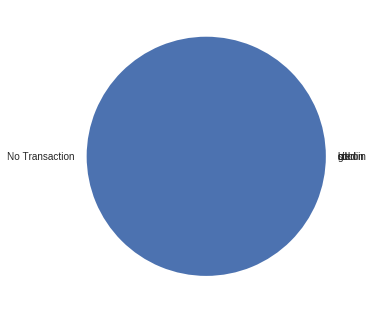

In [0]:
from matplotlib import pyplot 
pyplot.pie(model.predict(x_test)[0], explode=None, labels = ['No Transaction']+market)[1]